In [1]:
# Adjust the import according to what you installed
import gymnasium as gym

# Attempt to create and reset an environment
env = gym.make('CartPole-v1')  # Ensure 'CartPole-v1' is available in the installed package
env.reset()
print("Environment is ready.")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import sys
sys.path.append("../")

import os 
import optuna

from mbt_gym.agents.SbAgent import SbAgent

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, RunningInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel, BrownianMotionJumpMidpriceModel, BrownianMotionJumpMidpriceModelTesting
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel, HawkesArrivalModel, HawkesArrivalModelTesting
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics, LimitOrderModelDynamicsTesting
from mbt_gym.gym.backtesting import get_sharpe_ratio
from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory, plot_stable_baselines_actions

import importlib

Environment is ready.


In [2]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(100 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [3]:
def get_Hk_OF(num_trajectories:int = 1):
    fill_exponent = 2
    sigma = 1
    initial_inventory = (0, 1) # 0$ in cash and 1$ dollars in stock
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionJumpMidpriceModel(volatility=sigma, step_size=1/n_steps, jump_size=1,
                                                 num_trajectories=num_trajectories)
    
    # I should maybe specify the baseline rate
    arrival_model = HawkesArrivalModel(step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = RunningInventoryPenalty(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)

    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [4]:
num_trajectories = 100
env = (get_Hk_OF(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

# Vectorize the environment so it can train the n environment at each step
sb_env = VecMonitor(sb_env)

# Add directory for tensorboard logging and best model
base_tensorboard_logdir = "./ppo_tensorboard/"
best_model_path = "./SB_models/PPO-best-CJ"

agent_name = "jump = 1, sigma = 2, epoch 5"
tensorboard_logdir = os.path.join(base_tensorboard_logdir, agent_name)

# Architecture of the policy network

policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]) # two hidden layers containing 256 units each for policy network and value function

PPO_params = {"policy":'MlpPolicy', # Multi-layer perceptron policy
              "env": sb_env,
              #"learning_rate": 0.005,
              "verbose":1, # Print out training information
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":5, # Number of epochs
              "batch_size": int(n_steps * num_trajectories / 10), # Number of batch
              "n_steps": int(n_steps)} # Number of steps to run for each environment per update

callback_params = dict(eval_env=sb_env, n_eval_episodes = 200, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")



d:\Anaconda3\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")
d:\Anaconda3\lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cpu device


In [5]:
model.learn(total_timesteps = 5_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./ppo_tensorboard/jump = 1, sigma = 2, epoch 5\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -158     |
| time/              |          |
|    fps             | 49292    |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 100000   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -146         |
| time/                   |              |
|    fps                  | 24060        |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0029195007 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84    

In [6]:
def trading_test(df: pd.DataFrame, num_trajectories:int = 1):
    fill_exponent = 2
    sigma = 0.0001
    initial_inventory = (0, 1) # 0$ in cash and 1$ dollars in stock
    initial_price = df.iloc[0, 1] # Midprice at first time step
    step_size = df.iloc[1, 0] # 0.25
    n_steps = df.shape[0] # Number of rows
    terminal_time = df.iloc[-1, 0] # In seconds
    timestamps = np.linspace(0, terminal_time, n_steps)
    
    midprice_model = BrownianMotionJumpMidpriceModelTesting(
        volatility=sigma, 
        step_size=step_size, 
        jump_size=1,
        num_trajectories=num_trajectories,
        initial_price=initial_price,
        data=df['midprice']
    )
    
    arrival_model = HawkesArrivalModelTesting(
        baseline_arrival_rate=np.array([[1.0, 1.0]]),
        step_size=step_size,
        num_trajectories=num_trajectories,
        data=df['arrivals']
    )
    
    fill_probability_model = ExponentialFillFunction(
        fill_exponent=fill_exponent, 
        step_size=step_size,
        num_trajectories=num_trajectories
    )
    
    LOtrader = LimitOrderModelDynamicsTesting(
        midprice_model = midprice_model,
        arrival_model = arrival_model, 
        fill_probability_model = fill_probability_model,
        num_trajectories = num_trajectories
    )
    
    reward_function = RunningInventoryPenalty(
        per_step_inventory_aversion = phi,
        terminal_inventory_aversion = alpha
    )

    env_params = dict(
        terminal_time=terminal_time, 
        n_steps=n_steps,
        initial_inventory = initial_inventory,
        model_dynamics = LOtrader,
        max_inventory=n_steps,
        normalise_action_space = False,
        normalise_observation_space = False,
        reward_function = reward_function,
        num_trajectories=num_trajectories
    )
    
    return TradingEnvironment(**env_params)

In [7]:
df = pd.read_pickle('lob-BTCUSDT-20240401.pkl')
sb_env = (trading_test(df=df, num_trajectories=1))
# sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [8]:
ppo_agent = SbAgent(model)

observations, actions, rewards = generate_trajectory(sb_env, ppo_agent)

# Squeeze for the dimenson
rewards = np.squeeze(rewards, axis=1)

# Disregard the end value of observation (starting env)
observations = observations[:,:,:-1]

(1, 2, 14401)


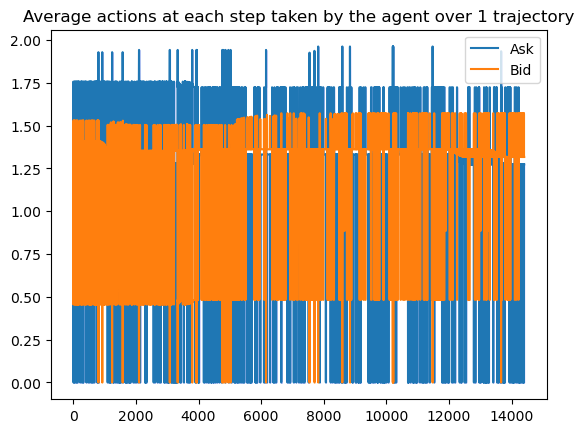

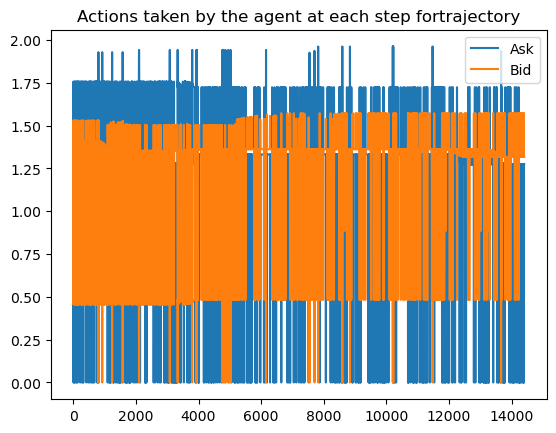

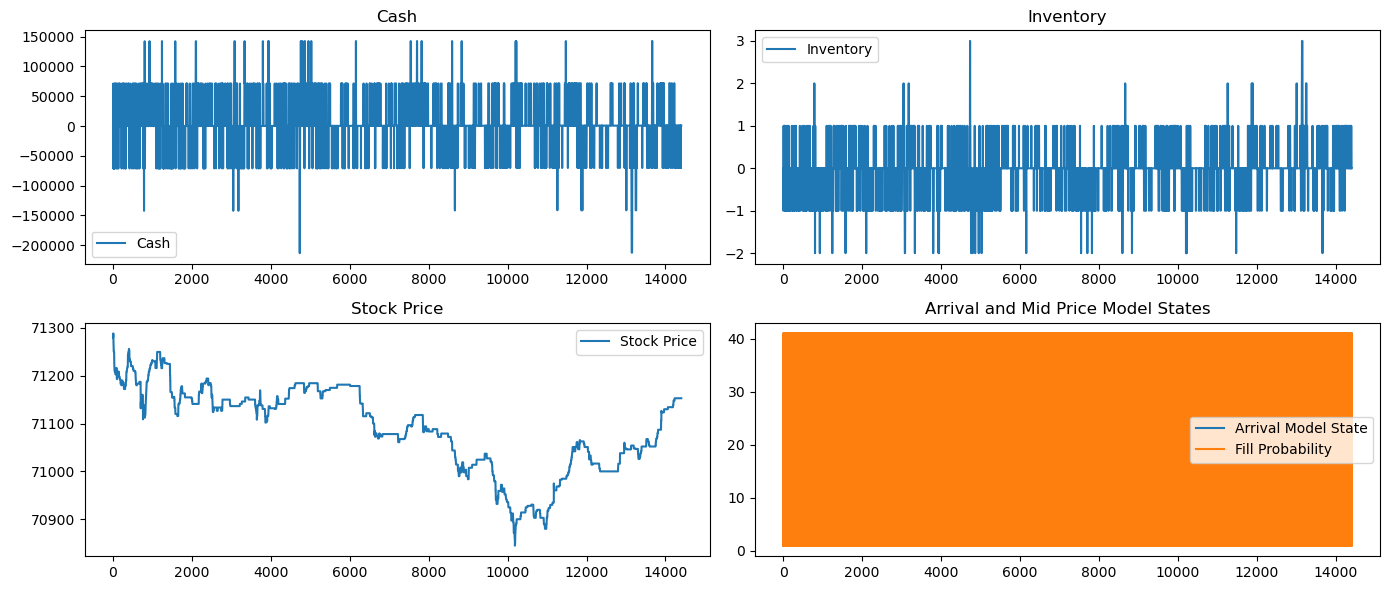

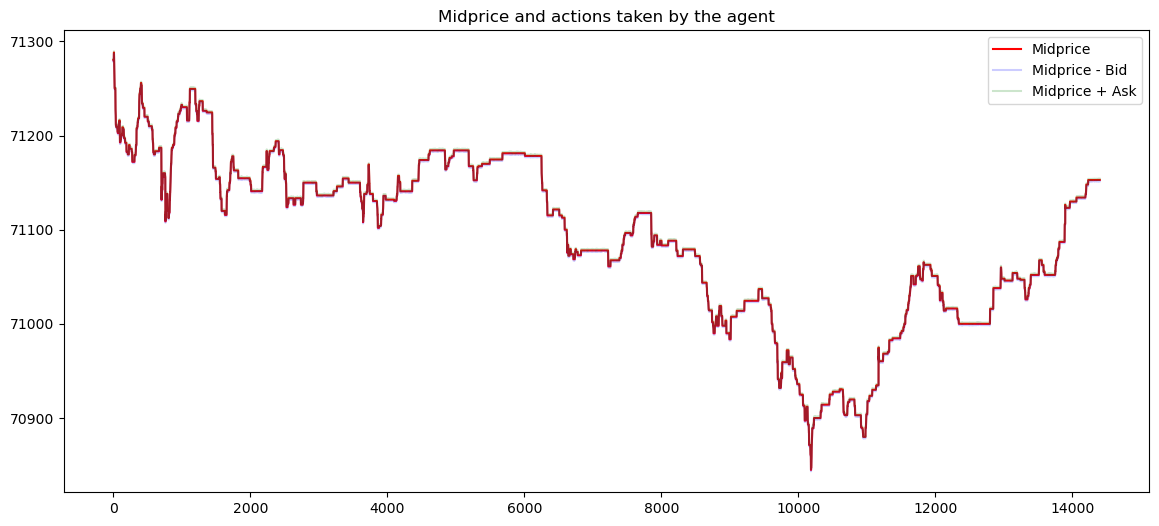

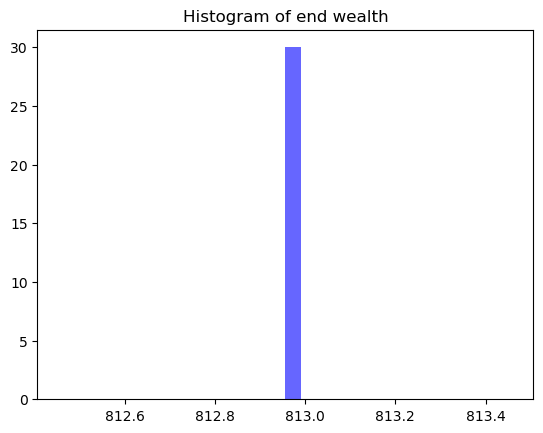

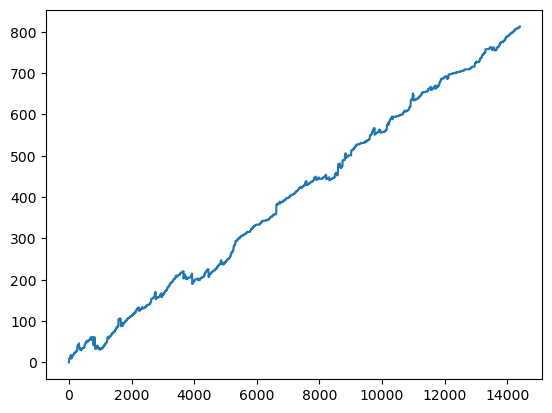

In [9]:
n_steps = df.shape[0] # Number of rows
print(actions.shape)
mean_actions_ask = actions[:,1,:].mean(axis=0)
mean_actions_bid = actions[:,0,:].mean(axis=0)

std_ask = actions[:,1,:].std(axis=0)
std_bid = actions[:,0,:].std(axis=0)

mean_actions_ask.shape
mean_actions_bid.shape

plt.plot(mean_actions_ask, label = "Ask")
plt.plot(mean_actions_bid, label = "Bid")
plt.fill_between(np.arange(0, n_steps), mean_actions_ask - std_ask , mean_actions_ask + std_ask , color = 'blue', alpha = 0.2)
plt.fill_between(np.arange(0, n_steps), mean_actions_bid - std_bid , mean_actions_bid + std_bid , color = 'orange', alpha = 0.2)

plt.title("Average actions at each step taken by the agent over 1 trajectory")
plt.legend()
plt.show()

plt.plot(actions[0,1,:], label = "Ask")
plt.plot(actions[0,0,:], label= "Bid")
plt.title("Actions taken by the agent at each step for trajectory")
plt.legend()
plt.show()

cum_rewards = np.cumsum(rewards, axis=-1)

# plt.plot(cum_rewards[200])
# plt.title("Cumulative reward at a given step")
# plt.xlabel("Step")
# plt.ylabel("Cumulative reward")
# plt.show()

# plt.hist(cum_rewards[:,-1], bins = 50, density = True, alpha = 0.6, color = 'b')
# plt.title("Histogram of cumulative rewards at the end of the episode")
# plt.show()


j = 0

# Create a 3x2 panel for plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Plot different features in each subplot
axes[0, 0].plot(observations[j, 0, :], label='Cash')
axes[0, 0].set_title('Cash')
axes[0, 0].legend()

axes[0, 1].plot(observations[j, 1, :], label='Inventory')
axes[0, 1].set_title('Inventory')
axes[0, 1].legend()

axes[1, 0].plot(observations[j, 3, :], label='Stock Price')
axes[1, 0].set_title('Stock Price')
axes[1, 0].legend()

axes[1, 1].plot(observations[j, 4, :], label='Arrival Model State')
axes[1, 1].plot(observations[j, 5, :], label='Fill Probability')
axes[1, 1].set_title('Arrival and Mid Price Model States')
axes[1, 1].legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(observations[j, 3, :], label = "Midprice", color = 'red')
     
plt.plot(observations[j, 3, :] - actions[0, 0, :], label = "Midprice - Bid", color = 'blue', alpha = 0.2)
plt.plot(observations[j, 3, :] + actions[0, 1, :], label = "Midprice + Ask", color = 'green', alpha = 0.2)
plt.title("Midprice and actions taken by the agent")
plt.legend()    
plt.show()


endmoney = observations[:, 1, :] * observations[:, 3, :] + observations[:, 0, :]

plt.hist(endmoney[:,-1], bins = 30, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of end wealth")
plt.show()

mean_wealth = endmoney.mean(axis=0)

plt.plot(mean_wealth)

In [10]:
cum_rewards = np.cumsum(rewards, axis=-1)
print(cum_rewards.shape)

(1, 14401)


We plot the result for the worst scenerio

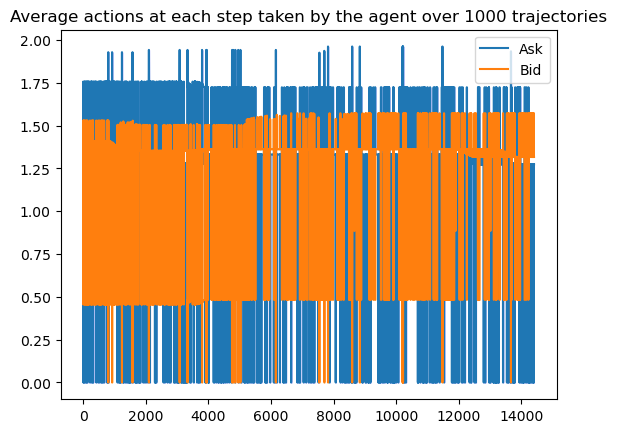

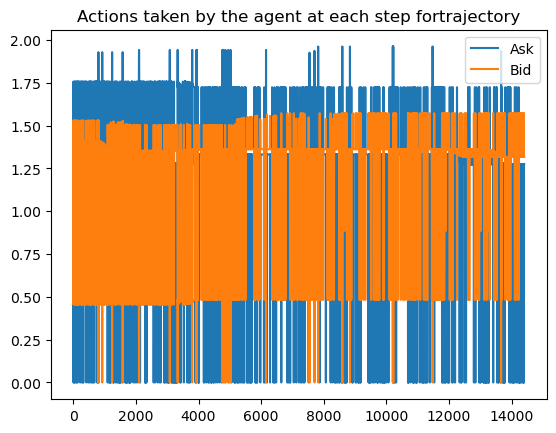

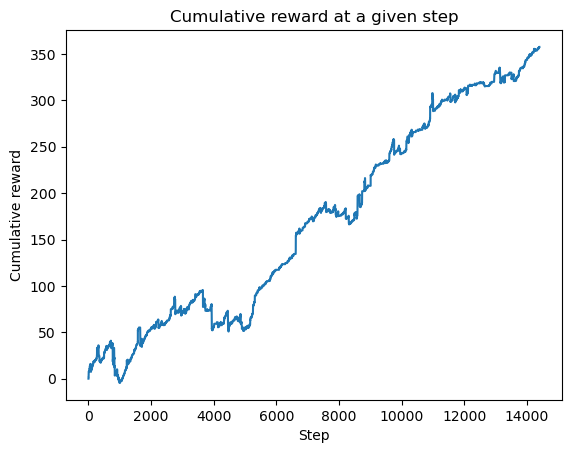

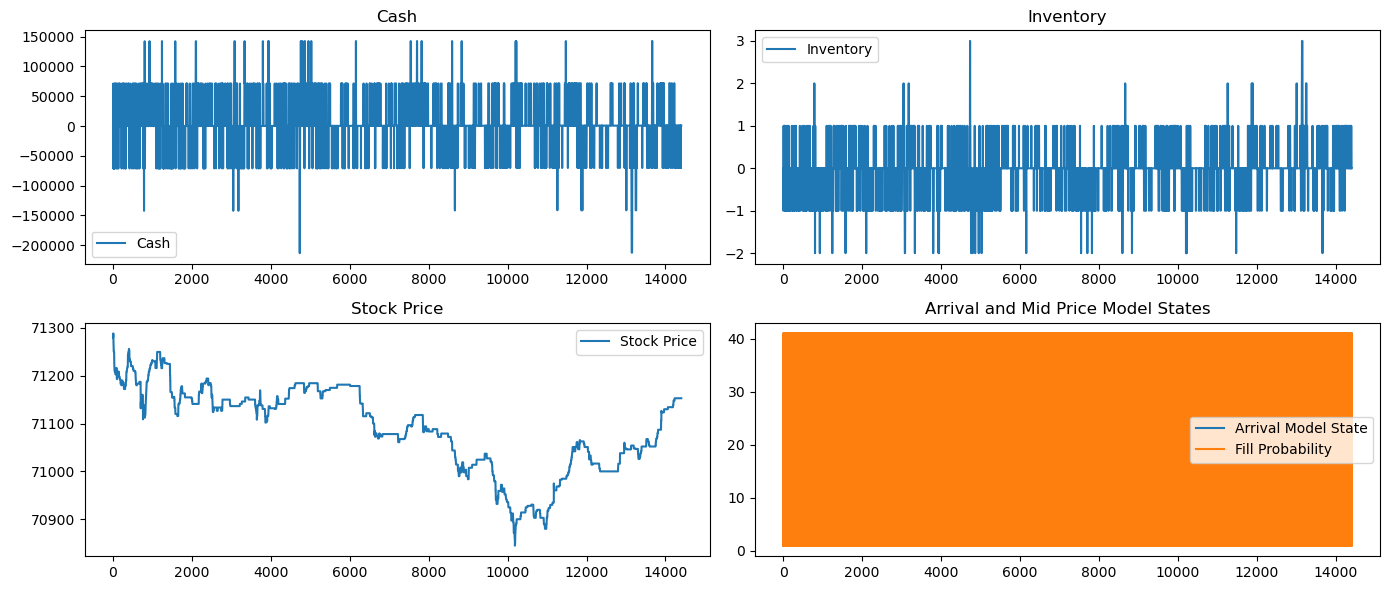

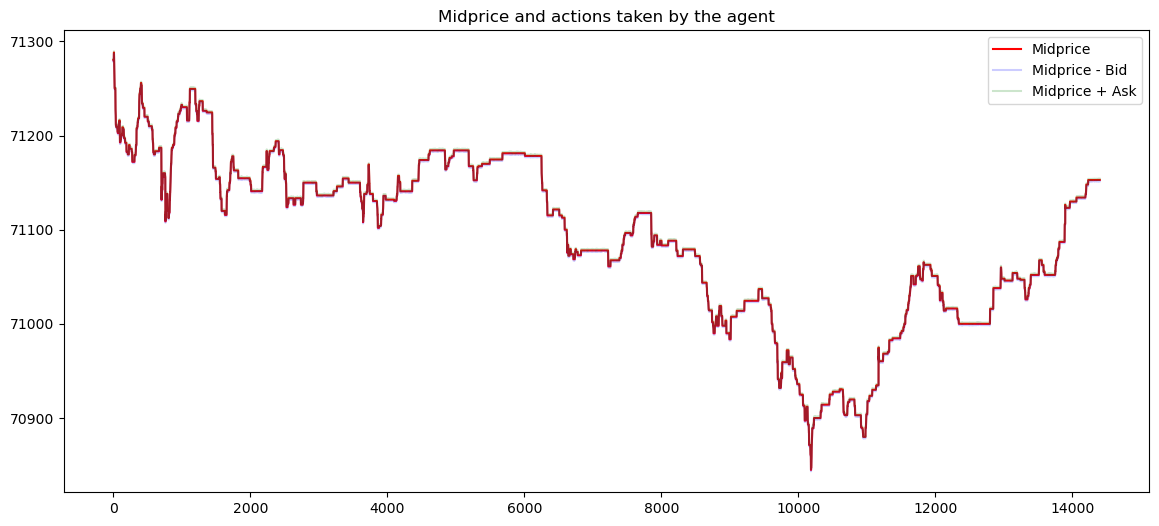

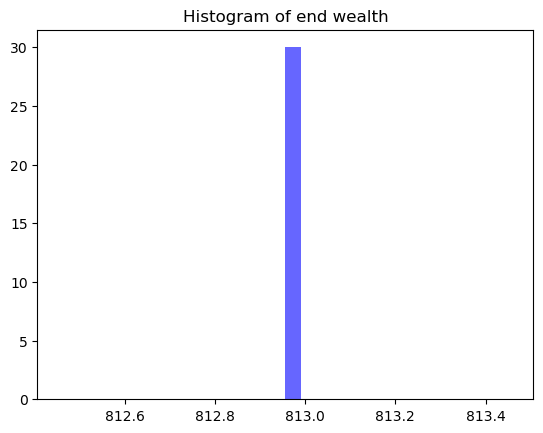

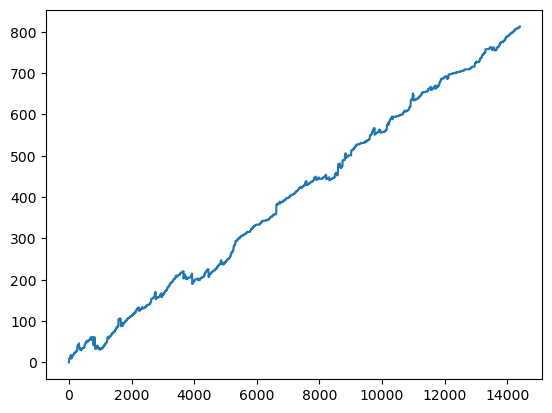

In [12]:
j = np.argmin(endmoney[:,-1])

mean_actions_ask = actions[:,1,:].mean(axis=0)
mean_actions_bid = actions[:,0,:].mean(axis=0)

std_ask = actions[:,1,:].std(axis=0)
std_bid = actions[:,0,:].std(axis=0)

mean_actions_ask.shape
mean_actions_bid.shape

plt.plot(mean_actions_ask, label = "Ask")
plt.plot(mean_actions_bid, label = "Bid")
plt.fill_between(np.arange(0, n_steps), mean_actions_ask - std_ask , mean_actions_ask + std_ask , color = 'blue', alpha = 0.2)
plt.fill_between(np.arange(0, n_steps), mean_actions_bid - std_bid , mean_actions_bid + std_bid , color = 'orange', alpha = 0.2)

plt.title("Average actions at each step taken by the agent over 1000 trajectories")
plt.legend()
plt.show()

plt.plot(actions[j,1,:], label = "Ask")
plt.plot(actions[j,0,:], label= "Bid")
plt.title("Actions taken by the agent at each step fortrajectory")
plt.legend()
plt.show()

cum_rewards = np.cumsum(rewards, axis=-1)

plt.plot(cum_rewards[j])
plt.title("Cumulative reward at a given step")
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.show()

# plt.hist(cum_rewards[:,-1], bins = 50, density = True, alpha = 0.6, color = 'b')
# plt.title("Histogram of cumulative rewards at the end of the episode")
# plt.show()

# Create a 3x2 panel for plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Plot different features in each subplot
axes[0, 0].plot(observations[j, 0, :], label='Cash')
axes[0, 0].set_title('Cash')
axes[0, 0].legend()

axes[0, 1].plot(observations[j, 1, :], label='Inventory')
axes[0, 1].set_title('Inventory')
axes[0, 1].legend()

axes[1, 0].plot(observations[j, 3, :], label='Stock Price')
axes[1, 0].set_title('Stock Price')
axes[1, 0].legend()

axes[1, 1].plot(observations[j, 4, :], label='Arrival Model State')
axes[1, 1].plot(observations[j, 5, :], label='Fill Probability')
axes[1, 1].set_title('Arrival and Mid Price Model States')
axes[1, 1].legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(observations[j, 3, :], label = "Midprice", color = 'red')
         
plt.plot(observations[j, 3, :] - actions[0, 0, :], label = "Midprice - Bid", color = 'blue', alpha = 0.2)
plt.plot(observations[j, 3, :] + actions[0, 1, :], label = "Midprice + Ask", color = 'green', alpha = 0.2)
plt.title("Midprice and actions taken by the agent")
plt.legend()    
plt.show()

endmoney = observations[:, 1, :] * observations[:, 3, :] + observations[:, 0, :]

plt.hist(endmoney[:,-1], bins = 30, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of end wealth")
plt.show()

mean_wealth = endmoney.mean(axis=0)

plt.plot(mean_wealth)